# Basic feature interrelation analysis using the 'fip3' library

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import csv

from fip import profiles

In [2]:
DATASET_NAME = 'ChEMBL28'
DATASET_LINK = '../../scratch/data/chembl_28/chembl_compounds_activities_features.csv'
OUTPUT_FIGURE_PATH = '../../scratch/data/chembl_28/pix'

FEATURES_NAME = 'ECFP1-like substructures'
COOCCURRENCE_MX_LINK = '../../scratch/data/chembl_28/ec_fragments_r1_coomx.csv'
COOCCURRENCE_MX_VECTOR_COUNT = 2066376

MINIMAL_COOCCURRENCE_CUTOFF = 100  # How many co-occurrences are needed to start tracking the relation

HYBRID_FEATURES_NAME = FEATURES_NAME + " and ChEMBL activities"
HYBRID_COOCCURRENCE_MX_LINK = '../../scratch/data/chembl_28/ec_fragments_r1_activities_coomx.csv'
HYBRID_COOCCURRENCE_MX_VECTOR_COUNT = COOCCURRENCE_MX_VECTOR_COUNT

REFERENCE_DATASET_NAME = 'ZINC_DM'
REFERENCE_DATASET_LINK = '../../scratch/data/zinc_dark_matter/zinc_dm_in_stock_features.csv'
REFERENCE_COOCCURRENCE_MX_LINK = '../../scratch/data/zinc_dark_matter/zinc_dm_in_stock_ec_fragments_r1_coomx.csv'
REFERENCE_COOCCURRENCE_MX_VECTOR_COUNT = 5063486

# Derived from primary dataset, adjusted for size difference
REFERENCE_MINIMAL_COOCCURRENCE_CUTOFF = int(MINIMAL_COOCCURRENCE_CUTOFF * 
                                            (REFERENCE_COOCCURRENCE_MX_VECTOR_COUNT /
                                             COOCCURRENCE_MX_VECTOR_COUNT))

TRACKED_FEATURES = ['Cannabinoid CB1 receptor']

## Loading an interrelation profile
From interrelation files already preprocessed by scripts in fip3/scripts

In [3]:
p = profiles.CooccurrenceProfile.from_dataframe(
    pd.read_csv(COOCCURRENCE_MX_LINK), min_cutoff_value=MINIMAL_COOCCURRENCE_CUTOFF)
p

In [4]:
p.df

value
feature1   feature2                
C=O        C=O              1424230
           Cc(c)c            624876
           c-n(c)n            37580
           c=O               120205
           cC                273990
...                             ...
N=c([nH])n cc(c)Cl              141
CCS        cN=S                 149
cn(c)n     nc(-n)[nH]           565
CC(N)=O    cS(F)(F)(F)(F)F      106
CC(F)(F)F  nc(-n)[nH]           175

[47478 rows x 1 columns]

## General characterization of a co-occurrence profile

In [5]:
print(f"There are {len(p.distinct_features())} distinct {FEATURES_NAME} within {DATASET_NAME}.")

There are 897 distinct ECFP1-like substructures within ChEMBL28.


In [6]:
self_relations_values = p.select_self_relations()['value']
self_relations_values

feature1    feature2  
C=O         C=O           1424230
Cc(c)c      Cc(c)c         717878
c-n(c)n     c-n(c)n         55340
c=O         c=O            222434
cC          cC             408262
                           ...   
c-c(c)[o+]  c-c(c)[o+]        134
nc(n)[nH]   nc(n)[nH]         120
N=c(n)[nH]  N=c(n)[nH]        117
CC(C)=c     CC(C)=c           122
cn(C)[se]   cn(C)[se]         109
Name: value, Length: 897, dtype: int64

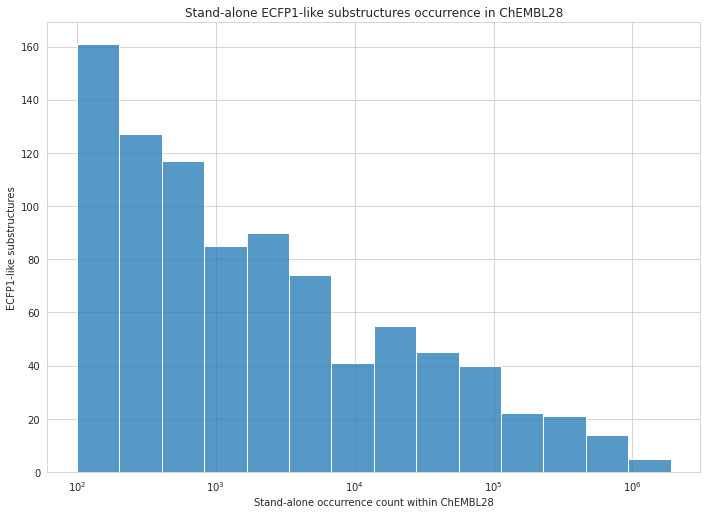

In [7]:
title = f"Stand-alone {FEATURES_NAME} occurrence in {DATASET_NAME}"
a4_dims = (11.7, 8.27)
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=a4_dims)
sns.histplot(self_relations_values, log_scale=True)
ax.set(title=title, xlabel=f"Stand-alone occurrence count within {DATASET_NAME}", ylabel=f"{FEATURES_NAME}")
plt.savefig(f"{OUTPUT_FIGURE_PATH}/{title}.svg", format="svg")
#plt.close()

In [8]:
cooccurrence_values = p.select_raw_interrelations()['value']
cooccurrence_values

feature1    feature2       
C=O         Cc(c)c             624876
            c-n(c)n             37580
            c=O                120205
            cC                 273990
            cC(c)=O             30748
                                ...  
N=c([nH])n  cc(c)Cl               141
CCS         cN=S                  149
cn(c)n      nc(-n)[nH]            565
CC(N)=O     cS(F)(F)(F)(F)F       106
CC(F)(F)F   nc(-n)[nH]            175
Name: value, Length: 46581, dtype: int64

In [9]:
print(f"There is in total {self_relations_values.sum()} feature stand-alone occurrences and \
{cooccurrence_values.sum()} feature co-occurrences for {FEATURES_NAME} within {DATASET_NAME}")

There is in total 33688980 feature stand-alone occurrences and 276946302 feature co-occurrences for ECFP1-like substructures within ChEMBL28


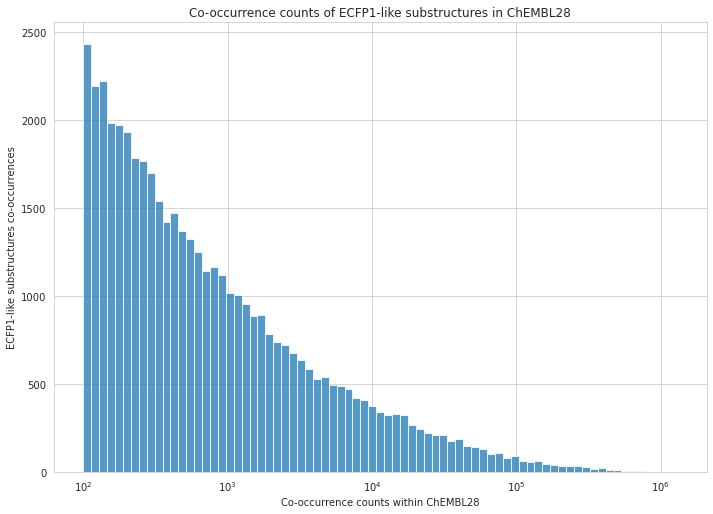

In [10]:
title = f"Co-occurrence counts of {FEATURES_NAME} in {DATASET_NAME}"
a4_dims = (11.7, 8.27)
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=a4_dims)
sns.histplot(cooccurrence_values, log_scale=True)
ax.set(title=title, xlabel=f"Co-occurrence counts within {DATASET_NAME}",
       ylabel=f"{FEATURES_NAME} co-occurrences")
plt.savefig(f"{OUTPUT_FIGURE_PATH}/{title}.svg", format="svg")
#plt.close()

In [11]:
print(f"The maximum theoretical number of different feature interrelations of the observed {FEATURES_NAME} \
within {DATASET_NAME} would be {int(p.num_max_interrelations())}, whereas the number of actual observed \
interrelations is only {p.num_raw_interrelations()}. Therefore, the interrelation matrix population ratio is \
approx. {p.num_raw_interrelations() / p.num_max_interrelations():.4f}.")

The maximum theoretical number of different feature interrelations of the observed ECFP1-like substructures within ChEMBL28 would be 401856, whereas the number of actual observed interrelations is only 46581. Therefore, the interrelation matrix population ratio is approx. 0.1159.


In [12]:
print(f"The mean co-occurrence value for {FEATURES_NAME} within {DATASET_NAME} \
is {p.mean_raw_interrelation_value():.2f}, \
with the standard deviation of {p.standard_raw_interrelation_deviation():.2f}. \
The mean stand-alone value is {p.mean_self_relation_value():.2f}, \
with the standard deviation of {p.standard_self_relation_deviation():.2f}.")

The mean co-occurrence value for ECFP1-like substructures within ChEMBL28 is 5945.48, with the standard deviation of 30064.68. The mean stand-alone value is 37557.39, with the standard deviation of 139526.54.


## General characterization of pointwise mutual information profile

In [13]:
p = profiles.CooccurrenceProbabilityProfile.from_cooccurrence_profile(
    p, vector_count=COOCCURRENCE_MX_VECTOR_COUNT)
p

In [14]:
p.select_self_relations()['value']

feature1    feature2  
C=O         C=O           0.689240
Cc(c)c      Cc(c)c        0.347409
c-n(c)n     c-n(c)n       0.026781
c=O         c=O           0.107644
cC          cC            0.197574
                            ...   
c-c(c)[o+]  c-c(c)[o+]    0.000065
nc(n)[nH]   nc(n)[nH]     0.000058
N=c(n)[nH]  N=c(n)[nH]    0.000057
CC(C)=c     CC(C)=c       0.000059
cn(C)[se]   cn(C)[se]     0.000053
Name: value, Length: 897, dtype: float64

In [15]:
p.select_self_relations()['value'].min()

4.8393903142506496e-05

In [16]:
p.select_raw_interrelations()['value'].min()

4.8393903142506496e-05

In [17]:
p = profiles.PointwiseMutualInformationProfile.from_cooccurrence_probability_profile(p)

p

In [18]:
p.df

value
feature1   feature2                 
C=O        C=O              0.000000
           Cc(c)c           0.336752
           c-n(c)n         -0.021437
           c=O             -0.350960
           cC              -0.038451
...                              ...
N=c([nH])n cc(c)Cl          1.755450
CCS        cN=S             2.678707
cn(c)n     nc(-n)[nH]       4.683056
CC(N)=O    cS(F)(F)(F)(F)F  0.540092
CC(F)(F)F  nc(-n)[nH]       2.898813

[47478 rows x 1 columns]

In [19]:
pmi_values = p.select_raw_interrelations()['value']
pmi_values

feature1    feature2       
C=O         Cc(c)c             0.336752
            c-n(c)n           -0.021437
            c=O               -0.350960
            cC                -0.038451
            cC(c)=O            0.536921
                                 ...   
N=c([nH])n  cc(c)Cl            1.755450
CCS         cN=S               2.678707
cn(c)n      nc(-n)[nH]         4.683056
CC(N)=O     cS(F)(F)(F)(F)F    0.540092
CC(F)(F)F   nc(-n)[nH]         2.898813
Name: value, Length: 46581, dtype: float64

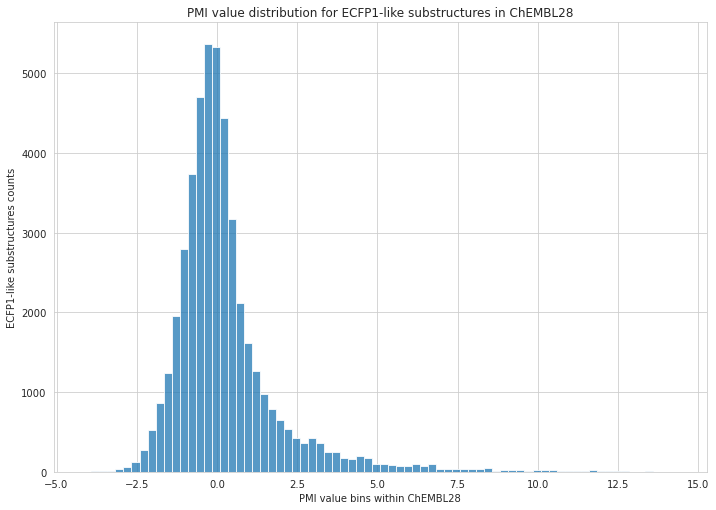

In [20]:
title = f"PMI value distribution for {FEATURES_NAME} in {DATASET_NAME}"
a4_dims = (11.7, 8.27)
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=a4_dims)
sns.histplot(pmi_values, binwidth=0.25)
ax.set(title=title, xlabel=f"PMI value bins within {DATASET_NAME}", ylabel=f"{FEATURES_NAME} counts")
plt.savefig(f"{OUTPUT_FIGURE_PATH}/{title}.svg", format="svg")
#plt.close()

In [21]:
print(f"The mean PMI value for {FEATURES_NAME} within {DATASET_NAME} \
is {p.mean_raw_interrelation_value():.2f}, \
with the standard deviation of {p.standard_raw_interrelation_deviation():.2f}. \
The mean stand-alone value is {p.mean_self_relation_value():.2f}, \
with the standard deviation of {p.standard_self_relation_deviation():.2f}.")

The mean PMI value for ECFP1-like substructures within ChEMBL28 is 0.25, with the standard deviation of 1.70. The mean stand-alone value is 0.00, with the standard deviation of 0.00.


In [22]:
major_pmi_values = p.select_major_interrelations(2)['value']
major_pmi_values

feature1     feature2  
c-n(c)n      cc(c)-n       4.251786
cc([nH])=O   nc([nH])=O    5.251617
C#N          cC#N          4.446057
cBr          cc(c)Br       4.726801
cC[n+]       c[n+](c)C     6.626132
                             ...   
c-c(c)o      nc(O)s        4.046249
CS(C)(=N)=O  cNc           4.148195
cN=S         cNc           4.374894
             ncn           3.816252
cn(c)n       nc(-n)[nH]    4.683056
Name: value, Length: 2089, dtype: float64

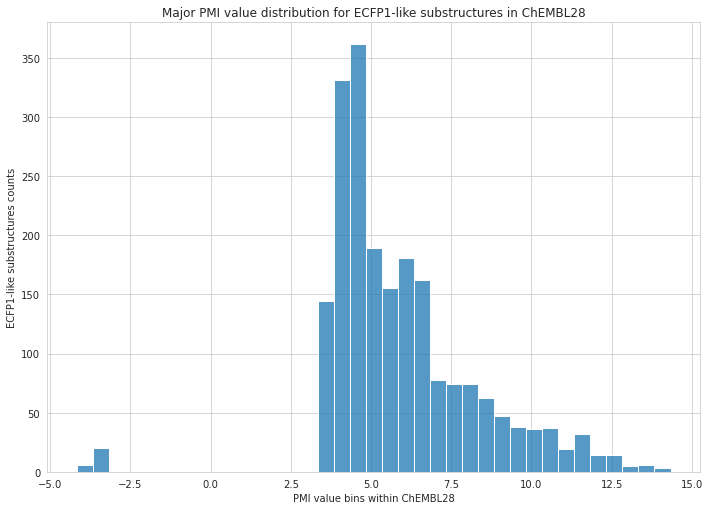

In [23]:
title = f"Major PMI value distribution for {FEATURES_NAME} in {DATASET_NAME}"
a4_dims = (11.7, 8.27)
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=a4_dims)
sns.histplot(major_pmi_values, binwidth=0.5)
ax.set(title=title, xlabel=f"PMI value bins within {DATASET_NAME}", ylabel=f"{FEATURES_NAME} counts")
plt.savefig(f"{OUTPUT_FIGURE_PATH}/{title}.svg", format="svg")
#plt.close()

In [24]:
p.mean_raw_interrelation_value()

0.2533206760082736

## Graph visualization of PMI profile

In [25]:
graph = nx.Graph()
major_pmi_values = p.select_major_interrelations(2)

for feature_pair, value in major_pmi_values[major_pmi_values['value'] > 0].iterrows():
    graph.add_edge(feature_pair[0], feature_pair[1], weight=float(value))
graph

Visualizations pending resolution of networkx<>matplotlib conda version incompatibility

title = f"Kamada-Kawai graph visualization of major PMI interrelations for {FEATURES_NAME} in {DATASET_NAME}"
dims = (40, 40)
fig, ax = plt.subplots(figsize=dims)
nx.draw_kamada_kawai(graph, ax=ax, alpha=0.5, node_size=30, label=title)
plt.savefig(f"{OUTPUT_FIGURE_PATH}/{title}.svg", format="svg")
plt.close()

title = f"Circular graph visualization of major PMI interrelations for {FEATURES_NAME} in {DATASET_NAME}"
dims = (40, 40)
fig, ax = plt.subplots(figsize=dims)
nx.draw_circular(graph, ax=ax, alpha=0.2, node_size=30)
plt.savefig(f"{OUTPUT_FIGURE_PATH}/{title}.svg", format="svg")
plt.close()

title = f"A generic graph visualization of major PMI interrelations for {FEATURES_NAME} in {DATASET_NAME}"
dims = (40, 40)
fig, ax = plt.subplots(figsize=dims)
nx.draw_networkx(graph, ax=ax, alpha=0.1, node_size=30)
plt.savefig(f"{OUTPUT_FIGURE_PATH}/{title}.svg", format="svg")
plt.close()

## General characterization of a hybrid co-occurrence profile

In [ ]:
q = profiles.CooccurrenceProfile.from_dataframe(
    pd.read_csv(HYBRID_COOCCURRENCE_MX_LINK), min_cutoff_value=MINIMAL_COOCCURRENCE_CUTOFF)
q

In [ ]:
q.df

In [ ]:
target_set = set()
with open(DATASET_LINK, 'r') as dataset:
    reader = csv.DictReader(dataset)
    for row in reader:
        activities = row['chembl_activities'].split(" | ")
        for activity in activities:
            activity = activity.strip()
            if activity:
                target_set.add(activity)
len(target_set)

In [ ]:
interrelation_type = ['feature-feature', 'feature-activity', 'activity-activity']
q.df['type'] = [interrelation_type[sum((x in target_set, y in target_set))]
                                   for x, y in zip(q.df.index.get_level_values(0),
                                                   q.df.index.get_level_values(1))]
q.df

In [ ]:
q.select_self_relations().loc[q.df.type=='activity-activity']

In [ ]:
print(f"There are {len(q.distinct_features())} distinct {HYBRID_FEATURES_NAME} within {DATASET_NAME}, \
of which there are {len(q.select_self_relations().loc[q.df.type=='activity-activity'])} ChEMBL activities.")

In [ ]:
hybrid_self_relations_values = q.select_self_relations()['value']
hybrid_self_relations_values

In [ ]:
title = f"Stand-alone {HYBRID_FEATURES_NAME} occurrence in {DATASET_NAME}"
a4_dims = (11.7, 8.27)
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=a4_dims)
sns.histplot(q.select_self_relations(), log_scale=True, discrete=True, 
             x="value", hue="type", multiple="stack")
ax.set(title=title, xlabel=f"Stand-alone occurrence count within {DATASET_NAME}",
       ylabel=f"{HYBRID_FEATURES_NAME}")
plt.savefig(f"{OUTPUT_FIGURE_PATH}/{title}.svg", format="svg")
#plt.close()

In [ ]:
hybrid_cooccurrence_values = q.select_raw_interrelations()['value']
hybrid_cooccurrence_values

In [ ]:
print(f"There is in total {self_relations_values.sum()} feature stand-alone occurrences and \
{hybrid_cooccurrence_values.sum()} feature co-occurrences for {HYBRID_FEATURES_NAME} within {DATASET_NAME}")

In [ ]:
title = f"Co-occurrence counts of {HYBRID_FEATURES_NAME} in {DATASET_NAME}"
a4_dims = (11.7, 8.27)
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=a4_dims)
sns.histplot(q.select_raw_interrelations(), log_scale=True, discrete=True,
             x="value", hue="type", multiple="stack")
ax.set(title=title, xlabel=f"Co-occurrence counts within {DATASET_NAME}",
       ylabel=f"{HYBRID_FEATURES_NAME} co-occurrences")
plt.savefig(f"{OUTPUT_FIGURE_PATH}/{title}.svg", format="svg")
#plt.close()

In [ ]:
q = profiles.CooccurrenceProbabilityProfile.from_cooccurrence_profile(
    q, vector_count=HYBRID_COOCCURRENCE_MX_VECTOR_COUNT)
q = profiles.PointwiseMutualInformationProfile.from_cooccurrence_probability_profile(q)

In [ ]:
q.df

In [ ]:
# Fix the type write-through
q.df['type'] = [interrelation_type[sum((x in target_set, y in target_set))]
                                   for x, y in zip(q.df.index.get_level_values(0),
                                                   q.df.index.get_level_values(1))]
q.df

In [ ]:
title = f"PMI value distribution for {HYBRID_FEATURES_NAME} in {DATASET_NAME}"
a4_dims = (11.7, 8.27)
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=a4_dims)
sns.histplot(q.select_raw_interrelations(), binwidth=0.25, x="value", hue="type", multiple="stack")
ax.set(title=title, xlabel=f"PMI value bins within {DATASET_NAME}", ylabel=f"{FEATURES_NAME} counts")
plt.savefig(f"{OUTPUT_FIGURE_PATH}/{title}.svg", format="svg")
#plt.close()

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(q.df.loc[q.df.type == 'activity-activity'].sort_values('value', ascending=False)[:100])

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(q.df.loc[q.df.type == 'feature-activity'].sort_values('value', ascending=False)[:100])

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(q.df.loc[q.df.type == 'feature-feature'].sort_values('value', ascending=False)[:100])

## Investigating specific interrelations

In [ ]:
# take only interrelations of pmi > 2, i.e. four times more occurring that what the marginal suggest 
q.df = q.df[q.df.value > 2]
q.df

In [ ]:
title = f"Filtered PMI value distribution for {HYBRID_FEATURES_NAME} in {DATASET_NAME}"
a4_dims = (11.7, 8.27)
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=a4_dims)
sns.histplot(q.select_raw_interrelations(), binwidth=0.25, x="value", hue="type", multiple="stack")
ax.set(title=title, xlabel=f"PMI value bins within {DATASET_NAME}", ylabel=f"{FEATURES_NAME} counts")
#plt.savefig(f"{OUTPUT_FIGURE_PATH}/{title}.svg", format="svg")
#plt.close()

In [ ]:
q.select_raw_interrelations_involving(TRACKED_FEATURES)

In [ ]:
tf = q.select_raw_interrelations_involving(TRACKED_FEATURES, 1)
tf

In [ ]:
graph = nx.Graph()
for feature_pair, row in tf.iterrows():
    graph.add_edge(feature_pair[0], feature_pair[1], weight=float(row['value']))
graph

In [ ]:
nodecolors = {'feature': '#0000ff', 'target': '#00ff00', 'highlight': '#ff0000'}
node2color = {node: nodecolors['target'] if node in target_set
              else nodecolors['feature'] for node in graph.nodes()}
for tracked in TRACKED_FEATURES:
    node2color[tracked] = nodecolors['highlight']

Visualizations pending resolution of networkx<>matplotlib conda version incompatibility

title = f"A PMI interrelation visualization for {TRACKED_FEATURES} using {FEATURES_NAME} in {DATASET_NAME}"
dims = (20, 20)
fig, ax = plt.subplots(figsize=dims)
ax.grid(False)
pos = nx.spring_layout(graph, scale=2)
edgewidth_coefficient = 0.3
edgewidths = [graph.edges[a, b]['weight']*edgewidth_coefficient for a, b in graph.edges()]
nx.draw_networkx_nodes(graph, ax=ax, node_size=30, pos=pos,
                       node_color = [node2color[node] for node in graph.nodes()]) 
nx.draw_networkx_edges(graph, ax=ax, alpha=0.3, width=edgewidths, pos=pos)
nx.draw_networkx_labels(graph, pos, font_size=2, bbox={"ec": "k", "fc": "white", "alpha": 0.7})
plt.savefig(f"{OUTPUT_FIGURE_PATH}/{title}.svg", format="svg")

## Characterization of reference interrelation profile

In [ ]:
r = profiles.CooccurrenceProfile.from_dataframe(
    pd.read_csv(REFERENCE_COOCCURRENCE_MX_LINK), min_cutoff_value=REFERENCE_MINIMAL_COOCCURRENCE_CUTOFF)
r

In [ ]:
r.df

In [ ]:
print(f"There are {len(r.distinct_features())} distinct {FEATURES_NAME} within {REFERENCE_DATASET_NAME}.")

In [ ]:
self_relations_values = r.select_self_relations()['value']
self_relations_values

In [ ]:
title = f"Stand-alone {FEATURES_NAME} occurrence in {REFERENCE_DATASET_NAME}"
a4_dims = (11.7, 8.27)
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=a4_dims)
sns.histplot(self_relations_values, log_scale=True)
ax.set(title=title, xlabel=f"Stand-alone occurrence count within {DATASET_NAME}", ylabel=f"{FEATURES_NAME}")
plt.savefig(f"{OUTPUT_FIGURE_PATH}/{title}.svg", format="svg")
#plt.close()

In [ ]:
cooccurrence_values = r.select_raw_interrelations()['value']
cooccurrence_values

In [ ]:
print(f"There is in total {self_relations_values.sum()} feature stand-alone occurrences and \
{cooccurrence_values.sum()} feature co-occurrences for {FEATURES_NAME} within {REFERENCE_DATASET_NAME}")

In [ ]:
title = f"Co-occurrence counts of {FEATURES_NAME} in {REFERENCE_DATASET_NAME}"
a4_dims = (11.7, 8.27)
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=a4_dims)
sns.histplot(cooccurrence_values, log_scale=True)
ax.set(title=title, xlabel=f"Co-occurrence counts within {DATASET_NAME}",
       ylabel=f"{FEATURES_NAME} co-occurrences")
plt.savefig(f"{OUTPUT_FIGURE_PATH}/{title}.svg", format="svg")
#plt.close()

In [ ]:
print(f"The maximum theoretical number of different feature interrelations of the observed {FEATURES_NAME} \
within {REFERENCE_DATASET_NAME} would be {int(r.num_max_interrelations())}, whereas the number of actual observed \
interrelations is only {r.num_raw_interrelations()}. Therefore, the interrelation matrix population ratio is \
approx. {r.num_raw_interrelations() / r.num_max_interrelations():.4f}.")

In [ ]:
print(f"The mean co-occurrence value for {FEATURES_NAME} within {REFERENCE_DATASET_NAME} \
is {r.mean_raw_interrelation_value():.2f}, \
with the standard deviation of {r.standard_raw_interrelation_deviation():.2f}. \
The mean stand-alone value is {r.mean_self_relation_value():.2f}, \
with the standard deviation of {r.standard_self_relation_deviation():.2f}.")

## General characterization of reference pointwise mutual information profile

In [ ]:
r = profiles.CooccurrenceProbabilityProfile.from_cooccurrence_profile(
    r, vector_count=REFERENCE_COOCCURRENCE_MX_VECTOR_COUNT)
r.df

In [ ]:
r = profiles.PointwiseMutualInformationProfile.from_cooccurrence_probability_profile(r)
r.df

In [ ]:
title = f"PMI value distribution for {FEATURES_NAME} in {REFERENCE_DATASET_NAME}"
a4_dims = (11.7, 8.27)
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=a4_dims)
sns.histplot(r.select_raw_interrelations()['value'], binwidth=0.25)
ax.set(title=title, xlabel=f"PMI value bins within {DATASET_NAME}", ylabel=f"{FEATURES_NAME} counts")
plt.savefig(f"{OUTPUT_FIGURE_PATH}/{title}.svg", format="svg")
#plt.close()

## Graph visualization of reference PMI profile

In [ ]:
graph = nx.Graph()
major_pmi_values = r.select_major_interrelations(2)

for feature_pair, value in major_pmi_values[major_pmi_values['value'] > 0].iterrows():
    graph.add_edge(feature_pair[0], feature_pair[1], weight=float(value))
graph

Visualizations pending resolution of networkx<>matplotlib conda version incompatibility

title = f"Kamada-Kawai graph visualization of major PMI interrelations for {FEATURES_NAME} \
in {REFERENCE_DATASET_NAME}"
dims = (40, 40)
fig, ax = plt.subplots(figsize=dims)
nx.draw_kamada_kawai(graph, ax=ax, alpha=0.5, node_size=30, label=title)
plt.savefig(f"{OUTPUT_FIGURE_PATH}/{title}.svg", format="svg")
plt.close()

title = f"Circular graph visualization of major PMI interrelations for {FEATURES_NAME} in \
{REFERENCE_DATASET_NAME}"
dims = (40, 40)
fig, ax = plt.subplots(figsize=dims)
nx.draw_circular(graph, ax=ax, alpha=0.2, node_size=30)
plt.savefig(f"{OUTPUT_FIGURE_PATH}/{title}.svg", format="svg")
plt.close()

title = f"A generic graph visualization of major PMI interrelations for {FEATURES_NAME} in \
{REFERENCE_DATASET_NAME}"
dims = (40, 40)
fig, ax = plt.subplots(figsize=dims)
nx.draw_networkx(graph, ax=ax, alpha=0.1, node_size=30)
plt.savefig(f"{OUTPUT_FIGURE_PATH}/{title}.svg", format="svg")
plt.close()

## Using relative feature tightness measure against PMI profile

In [ ]:
# sampling random 

title = f"Kamada-Kawai graph visualization of major PMI interrelations for {FEATURES_NAME} \
in {REFERENCE_DATASET_NAME}"
dims = (40, 40)
fig, ax = plt.subplots(figsize=dims)
nx.draw_kamada_kawai(graph, ax=ax, alpha=0.5, node_size=30, label=title)
plt.savefig(f"{OUTPUT_FIGURE_PATH}/{title}.svg", format="svg")
plt.close()

title = f"Circular graph visualization of major PMI interrelations for {FEATURES_NAME} in \
{REFERENCE_DATASET_NAME}"
dims = (40, 40)
fig, ax = plt.subplots(figsize=dims)
nx.draw_circular(graph, ax=ax, alpha=0.2, node_size=30)
plt.savefig(f"{OUTPUT_FIGURE_PATH}/{title}.svg", format="svg")
plt.close()

title = f"A generic graph visualization of major PMI interrelations for {FEATURES_NAME} in \
{REFERENCE_DATASET_NAME}"
dims = (40, 40)
fig, ax = plt.subplots(figsize=dims)
nx.draw_networkx(graph, ax=ax, alpha=0.1, node_size=30)
plt.savefig(f"{OUTPUT_FIGURE_PATH}/{title}.svg", format="svg")
plt.close()

## Using relative feature tightness measure against PMI profile

In [ ]:
# sampling random 

## Comparing profiles using Pointwise KL Divergence

In [69]:
p = profiles.CooccurrenceProfile.from_dataframe(
    pd.read_csv(COOCCURRENCE_MX_LINK), min_cutoff_value=MINIMAL_COOCCURRENCE_CUTOFF)
p = profiles.CooccurrenceProbabilityProfile.from_cooccurrence_profile(
    p, vector_count=COOCCURRENCE_MX_VECTOR_COUNT)
p.df

value
feature1   feature2                 
C=O        C=O              0.689240
           Cc(c)c           0.302402
           c-n(c)n          0.018186
           c=O              0.058172
           cC               0.132594
...                              ...
N=c([nH])n cc(c)Cl          0.000068
CCS        cN=S             0.000072
cn(c)n     nc(-n)[nH]       0.000273
CC(N)=O    cS(F)(F)(F)(F)F  0.000051
CC(F)(F)F  nc(-n)[nH]       0.000085

[47478 rows x 1 columns]

In [70]:
r = profiles.CooccurrenceProfile.from_dataframe(
    pd.read_csv(REFERENCE_COOCCURRENCE_MX_LINK), min_cutoff_value=REFERENCE_MINIMAL_COOCCURRENCE_CUTOFF)
r = profiles.CooccurrenceProbabilityProfile.from_cooccurrence_profile(
    r, vector_count=REFERENCE_COOCCURRENCE_MX_VECTOR_COUNT)
r.df

value
feature1 feature2          
CCN      CCN       0.499327
         CCO       0.163191
         COC       0.145833
         Cn        0.027918
         Cn(n)n    0.000510
...                     ...
CC(c)n   cSc       0.000302
         cc(o)S    0.000152
C=C(C)N  cc(-n)s   0.000053
CN=c     cc(-n)s   0.000058
N=c(n)s  cc(-n)s   0.000058

[38277 rows x 1 columns]

In [71]:
k = profiles.PointwiseKLDivergenceProfile.from_cooccurrence_probability_profiles(p, r)
k.df

value
feature1 feature2          
C=O      C=O      -0.195532
         Cc(c)c   -0.042577
         c-n(c)n  -0.604856
         c=O      -0.613486
         cC       -1.073105
...                     ...
CC(c)n   cSc      -9.286288
         cc(o)S   -8.291935
C=C(C)N  cc(-n)s  -6.762255
CN=c     cc(-n)s  -6.906645
N=c(n)s  cc(-n)s  -6.911544

[54003 rows x 1 columns]

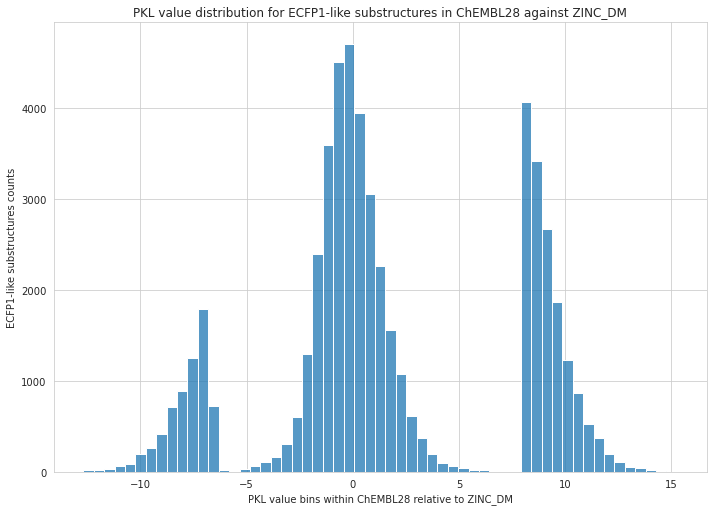

In [72]:
title = f"PKL value distribution for {FEATURES_NAME} in {DATASET_NAME} against {REFERENCE_DATASET_NAME}"
a4_dims = (11.7, 8.27)
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=a4_dims)
sns.histplot(k.select_raw_interrelations()['value'])
ax.set(title=title, xlabel=f"PKL value bins within {DATASET_NAME} relative to {REFERENCE_DATASET_NAME}",
       ylabel=f"{FEATURES_NAME} counts")
plt.savefig(f"{OUTPUT_FIGURE_PATH}/{title}.svg", format="svg")
#plt.close()

In [73]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(k.df.sort_values('value', ascending=False)[:100])

,,value
feature1,feature2,
CNO,NO,15.258272
C=N,cC(=N)N,14.596952
CO,OP,14.596381
O=P,cn(c)C,14.561717
CC(n)O,cN,14.511743
N=C(N)N,cc[nH],14.456521
CCS,N=C(N)N,14.437846
N=C(N)N,cc(c)[nH],14.234260
COC,OP,14.195969


In [74]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(k.df.sort_values('value', ascending=True)[:100])

value
feature1      feature2                
C=c(c)s       cBr           -12.684700
              cc(c)Br       -12.664800
CN=c          cBr           -12.654975
CC(C)=C       cI            -12.630021
CN=c          cc(c)Br       -12.628163
CC(C)=C       cc(c)I        -12.605385
cBr           cC=c          -12.604723
cC=c          cc(c)Br       -12.583681
c=NC          c[nH]c        -12.456109
CC(c)N        cC(=C)O       -12.448966
C=c(c)s       cCO           -12.384031
              cC(C)n        -12.381827
N=c(n)s       cC(C)n        -12.378956
cC=c          cCO           -12.377850
N=c(n)s       cCO           -12.338491
N=c([nH])[nH] c[nH]c        -12.319035
              N=c([nH])[nH] -12.319035
              ccc           -12.317190
CN=c          cCO           -12.299546
              cC(C)n        -12.268141
c=NC          cc(=N)[nH]    -12.262520
cC(C)n        cC=c          -12.249521
N=c([nH])[nH] c=NC          -12.196820
              cc(=N)[nH]    -12.193933
CC(c)n        cCO           -12.015312
cc(=N)[nH]    cc(c)N        -11.994108
C=Nn          CC(=O)O       -11.984260
cN=c          cc(=N)[nH]    -11.960377
cc(c)o        cn(c)N        -11.926141
C=Nn          cc(c)o        -11.904036
cC(=C)O       cC(C)N        -11.864319
c-c(c)[nH]    c=NC          -11.846364
N=c([nH])[nH] cc(c)N        -11.837543
              cN=c          -11.787124
C=c(c)s       CC(C)O        -11.770536
c=NC          cN=c          -11.770030
C=Nn          CC(C)O        -11.766486
CS(C)=O       CS(C)=O       -11.748289
              O=S           -11.748289
N=c([nH])[nH] c-c(c)[nH]    -11.742803
c-c(c)[nH]    cc(=N)[nH]    -11.742803
CC(C)O        cC=c          -11.684074
c-c(c)c       cc(=N)[nH]    -11.635121
CS(C)=O       ccc           -11.621918
CC(=N)O       CC(C)=C       -11.563204
C=C(C)N       cI            -11.537884
              cc(c)I        -11.513119
CC(C)N        cc(=N)[nH]    -11.504229
cc(=N)[nH]    cnc           -11.477430
CC(=N)O       cnn           -11.460398
C=c(c)s       [N+]=O        -11.436593
              [N+][O-]      -11.436593
              c[N+](=O)[O-] -11.436381
N=c([nH])[nH] c-c(c)c       -11.431913
CC(C)N        N=c([nH])[nH] -11.431273
CCC           N=c([nH])[nH] -11.430420
cC=c          cc(C)n        -11.421003
CC(=N)O       cc(N)n        -11.415625
C=c(c)s       cc(c)[N+]     -11.403940
              cc(C)n        -11.393692
cC=c          cc(c)[N+]     -11.393692
CN=c          [N+][O-]      -11.370086
              [N+]=O        -11.370086
              c[N+](=O)[O-] -11.369641
c-c(c)[nH]    cN=c          -11.350829
C=c(c)s       cI            -11.332681
cC=c          cI            -11.331540
N=c(n)s       cI            -11.326734
CN=c          cc(c)[N+]     -11.321912
              cI            -11.309903
C=c(c)s       cc(c)I        -11.296624
cC=c          cc(c)I        -11.295453
N=c(n)s       cc(c)I        -11.291230
CN=c          cc(c)I        -11.279910
NC(=S)S       cc(n)=O       -11.275404
C=O           CS(C)=O       -11.274216
CC(=N)O       cc(C)n        -11.258440
C=S           cn(c)c        -11.217489
CS(C)=O       cc(c)C        -11.205572
CC(=C)S       cn(c)c        -11.185237
CF            c=NC          -11.161015
N=c([nH])[nH] cnc           -11.148101
NC(=S)S       cn(c)c        -11.127459
              cc(n)n        -11.124561
N=c([nH])[nH] cc(c)C        -11.111050
CC(=N)O       NC(N)=O       -11.110783
C=c(c)s       cc(c)-n       -11.100631
CCN           cc(=N)[nH]    -11.099290
Cc(n)n        cC(C)S        -11.092296
C#N           cC=c          -11.088786
N=c([nH])[nH] ccn           -11.082827
CO            N=c([nH])[nH] -11.074114
CC(C)N        cN=c          -11.069464
O=S           cS(C)=O       -11.067545
cS(C)=O       cS(C)=O       -11.067545
cC=c          cc(c)-n       -11.063149
cI            cN=C          -11.060119
CCN           N=c([nH])[nH] -11.059568
CC(=C)S       cI            -11.045987
CC            N=c([nH])[nH] -11.044037

## Comparing profiles using Pointwise Jeffreys Divergence

In [75]:
j = profiles.PointwiseJeffreysDivergenceProfile.from_cooccurrence_probability_profiles(p, r)
j.df

value
feature1 feature2           
C=O      C=O        0.391064
         Cc(c)c     0.085153
         c-n(c)n    1.209712
         c=O        1.226971
         cC         2.146210
...                      ...
CC(c)n   cSc       18.572577
         cc(o)S    16.583870
C=C(C)N  cc(-n)s   13.524510
CN=c     cc(-n)s   13.813290
N=c(n)s  cc(-n)s   13.823087

[54003 rows x 1 columns]

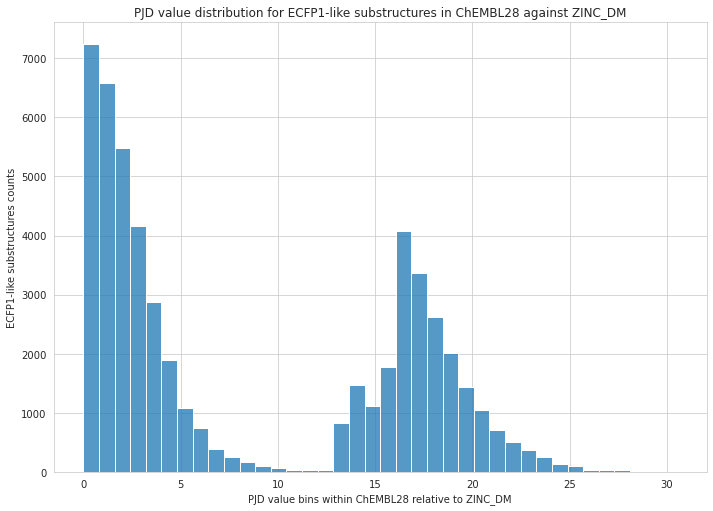

In [76]:
title = f"PJD value distribution for {FEATURES_NAME} in {DATASET_NAME} against {REFERENCE_DATASET_NAME}"
a4_dims = (11.7, 8.27)
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=a4_dims)
sns.histplot(j.select_raw_interrelations()['value'])
ax.set(title=title, xlabel=f"PJD value bins within {DATASET_NAME} relative to {REFERENCE_DATASET_NAME}",
       ylabel=f"{FEATURES_NAME} counts")
plt.savefig(f"{OUTPUT_FIGURE_PATH}/{title}.svg", format="svg")
#plt.close()

In [77]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(j.df.sort_values('value', ascending=False)[:100])

,,value
feature1,feature2,
CNO,NO,30.516543
C=N,cC(=N)N,29.193904
CO,OP,29.192762
O=P,cn(c)C,29.123433
CC(n)O,cN,29.023486
N=C(N)N,cc[nH],28.913042
CCS,N=C(N)N,28.875692
N=C(N)N,cc(c)[nH],28.468519
COC,OP,28.391938


In [78]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(j.df.sort_values('value', ascending=True)[:100])

,,value
feature1,feature2,
CC(C)N,cC(C)C,0.000150
CN(C)S,Cc(c)c,0.000164
CCc,cc(c)N,0.000175
COC,cC#N,0.000235
OCO,cc(c)s,0.000258
cC(C)=O,cOC,0.000271
C=CN,cc(c)c,0.000276
cN(c)c,cc(c)N,0.000578
C#N,c-c(n)n,0.000885
